In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


/home/seth/school/deep_learning


In [2]:
# !pip3 install torch
# !pip3 install torchvision
# !pip3 install tqdm
# from IPython import get_ipython


 <a href="https://colab.research.google.com/github/sethmnielsen/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Lab 3: Intro to CNNs and DNNs

 ## Objectives

 * Build and train a deep conv net
 * Explore and implement various initialization techniques
 * Implement a parameterized module in Pytorch
 * Use a principled loss function

 ## Video Tutorial
 [https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

 ## Deliverable
 For this lab, you will submit an ipython notebook via learningsuite.
 This is where you build your first deep neural network!

 For this lab, we'll be combining several different concepts that we've covered during class,
 including new layer types, initialization strategies, and an understanding of convolutions.

 ## Grading Standards:
 * 30% Part 0: Successfully followed lab video and typed in code
 * 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
 * 20% Part 2: Implement different initialization strategies
 * 10% Part 3: Print parameters, plot train/test accuracy
 * 10% Part 4: Convolution parameters quiz
 * 10% Tidy and legible figures, including labeled axes where appropriate
 ___

 ### Part 0
 Watch and follow video tutorial:

 [https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

 **TODO:**

 * Watch tutorial

 **DONE:**

In [3]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
from IPython.core.debugger import Pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"



In [4]:
# Use the dataset class you created in lab2


def count_parameters(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name, ':', 'x'.join(str(x)
                                          for x in list(param.size())), '=', num_param)
            else:
                print(name, ':', num_param)
            total_param += num_param
    return total_param


class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, ignore_index=-100,
                 reduce=None, reduction='mean'):
        self.__dict__.update(locals())
        super(CrossEntropyLoss, self).__init__()

    """ y_hat: Tensor of shape(batch_size, num_classes)
        y_truth: Tensor of shape(batch_size, 1) with entries in range [0,9]
    """

    def forward(self, y_hat, y_truth):
        """ - encode y_truth to shape(batch_size, num_classes) 
                    3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]; 
                    0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]; 
                    etc. You map an integer to an array of length n_classes, 
                    with a 1 in the index of the true class.
            - formula from CrossEntropyLoss
                For uniform/random initializaation, *can* modify Cross Entropy Loss 
                by using the log-sum-exp trick to avoid NaN/overflow
        """

        wrong_class_penalty = torch.log(torch.sum(torch.exp(y_hat), dim=1))
        batchsize, classes = y_hat.size()
        b = torch.zeros((batchsize, classes))
        # can I replace np.arange with ':'?
        b[np.arange(batchsize), y_truth] = 1
        true_class_preds = torch.sum(y_hat * b.cuda(), dim=1)

        return torch.mean(-true_class_preds + wrong_class_penalty)


class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, init_strategy='xav', stride=1, padding=0,
                 dilation=1, groups=1, bias=True, padding_mode='zeros'):
        self.__dict__.update(locals())
        super(Conv2d, self).__init__()

        # tensor of shape (out, in, k, k)
        self.weight = Parameter(torch.Tensor(
            self.out_channels, self.in_channels, *kernel_size))
        self.bias = Parameter(torch.Tensor(self.out_channels))

        self.bias.data.uniform_(0, 0)

        # Different initialization strategies for weights, specify with parameter:
        if init_strategy == 'xav':
            nn.init.xavier_uniform_(self.weight)
        elif init_strategy == 'orth':
            # orthogonal (SVD with numpy)
            M = np.random.random(
                (out_channels, in_channels*kernel_size[0]*kernel_size[1])).astype(np.float32)
            U, _, Vt = np.linalg.svd(M, full_matrices=False)
            if len(M) > len(M[0]):  # take V if M is wide, take U if tall
                mat = U
            else:
                mat = Vt
            W = mat.reshape((self.out_channels, self.n_channels, *kernel_size))
            self.weight.data = torch.from_numpy(W)
        elif init_strategy == 'uni':
            self.weight.data.uniform_(-1, 1)
        else:
            nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


class ConvNetwork(nn.Module):
    def __init__(self, dataset, initialization_strategy='xav'):
        super(ConvNetwork, self).__init__()
        x, y = dataset[0]
        c, h, w = x.size()  # c=numchannels, h=height, w=width
        output = 10  # number of final output channels; correspond to 10 classes

        self.net = nn.Sequential(
            # numchannels, numkernels/output channels, sz of conv_kernel, space added to img b4 convolve
            Conv2d(in_channels=c,  out_channels=10,
                   kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            Conv2d(in_channels=10, out_channels=30,
                   kernel_size=(3, 3), padding=(0, 0)),
            nn.ReLU(),
            Conv2d(in_channels=30, out_channels=64,
                   kernel_size=(3, 3), padding=(0, 0)),
            nn.ReLU(),
            Conv2d(in_channels=64, out_channels=300,
                   kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            Conv2d(in_channels=300, out_channels=250,
                   kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            Conv2d(in_channels=250, out_channels=100,
                   kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            Conv2d(in_channels=100, out_channels=40,
                   kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            Conv2d(40, output, (24, 24), padding=(0, 0)),
        )  # should produce a (batch_size x 10 x 1 x 1) tensor

        print('number of trainable parameters =', count_parameters(self.net))

    def forward(self, x):
        out = self.net(x).squeeze(2).squeeze(2)
        return out
        """ (n, 10, 1, 1)
            (n, 10, 1)  <-- squeezed dim 2
            (n, 10)     <-- squeezed dim 2 again
        """


class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(root,
                                          train=train,
                                          transform=transforms.ToTensor(),
                                          download=True)

    def __getitem__(self, i):
        x, y = self.data[i]
        return x, y

    def __len__(self):
        return len(self.data)  # 100



In [5]:
train_dataset = FashionMNISTProcessedDataset(
    '/home/seth/Downloads/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset(
    '/home/seth/Downloads/fashionmnist', train=False)
model = ConvNetwork(train_dataset)
model = model.cuda()
objective = CrossEntropyLoss()  # gotta code this up myself, same API as below
optimizer = optim.Adam(model.parameters(), lr=1e-4)

batch_size = 42
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          pin_memory=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        pin_memory=True)


0.weight : 10x1x3x3 = 90
0.bias : 10
2.weight : 30x10x3x3 = 2700
2.bias : 30
4.weight : 64x30x3x3 = 17280
4.bias : 64
6.weight : 300x64x3x3 = 172800
6.bias : 300
8.weight : 250x300x3x3 = 675000
8.bias : 250
10.weight : 100x250x3x3 = 225000
10.bias : 100
12.weight : 40x100x3x3 = 36000
12.bias : 40
14.weight : 10x40x24x24 = 230400
14.bias : 10
number of trainable parameters = 1360074


In [6]:

losses = []
validations = []
train_scores = []
val_scores = []
val_loss_mean = 0
val_score_mean = 0
num_epochs = 5
val_interval = 300  # num of iterations between validation tests

t_len = len(train_loader)
v_len = len(val_loader)
total_loops = t_len + (t_len // val_interval + 1) * v_len
time_start = time.time()
for epoch in range(num_epochs):

    loop = tqdm(total=total_loops, position=0, leave=False)

    for loop_count, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

        optimizer.zero_grad()
        y_hat = model(x)

        loss = objective(y_hat, y_truth)

        loss.backward()
        optimizer.step()

        # Accuracy calculation
        # softmax - convert to probabilities; can't use in cross entropy loss, but outside ok
        # gives tensor of most likely class for each item, same size as y_truth
        guesses = torch.softmax(y_hat, dim=1).argmax(dim=1)
        # returns tensor of guesses.size containing 1s for correct, 0s for incorrect
        # Calculate accuracy from this
        train_accuracy = (guesses == y_truth).float().mean()

        # Add to loss and scores histories
        losses.append(loss.item())
        train_scores.append(train_accuracy)

        # Update tqdm display
        loop.set_description(
            f'epoch:{epoch}, loss:{loss.item():.4f}, train_accuracy:{train_accuracy:.3f}')
        loop.update()

        if loop_count % val_interval == 0:
            # item returns float, so objective().item() gives loss (which is 1st element)
            val_losses = np.zeros(v_len)
            val_accuracies = np.zeros(v_len)

            for i, (x_val, y_truth_val) in enumerate(val_loader):
                x_val, y_truth_val = x_val.cuda(
                    async=True), y_truth_val.cuda(async=True)
                y_hat_val = model(x_val)
                val_losses[i] = objective(y_hat_val, y_truth_val).item()
                val_guesses = torch.softmax(y_hat_val, dim=1).argmax(dim=1)
                val_accuracies[i] = (val_guesses == y_truth_val).float().mean()
                loop.update()

            val_score_mean = np.mean(val_accuracies)
            val_loss_mean = np.mean(val_losses)


        validations.append(val_loss_mean)
        val_scores.append(val_score_mean)

            # val_loss_mean = np.mean([
            #             objective(
            #                 model(x_val.cuda()), y_truth_val.cuda()
            #             ).item()
            #             for x_val, y_truth_val in val_loader
            #         ])
            # validations.append((len(val_losses), val_loss_mean))
            # loop.update(v_len)

loop.update()

elapsed_time = time.time() - time_start
loop.update()
loop.close()



   --- Total time elapsed: 237.89 ---



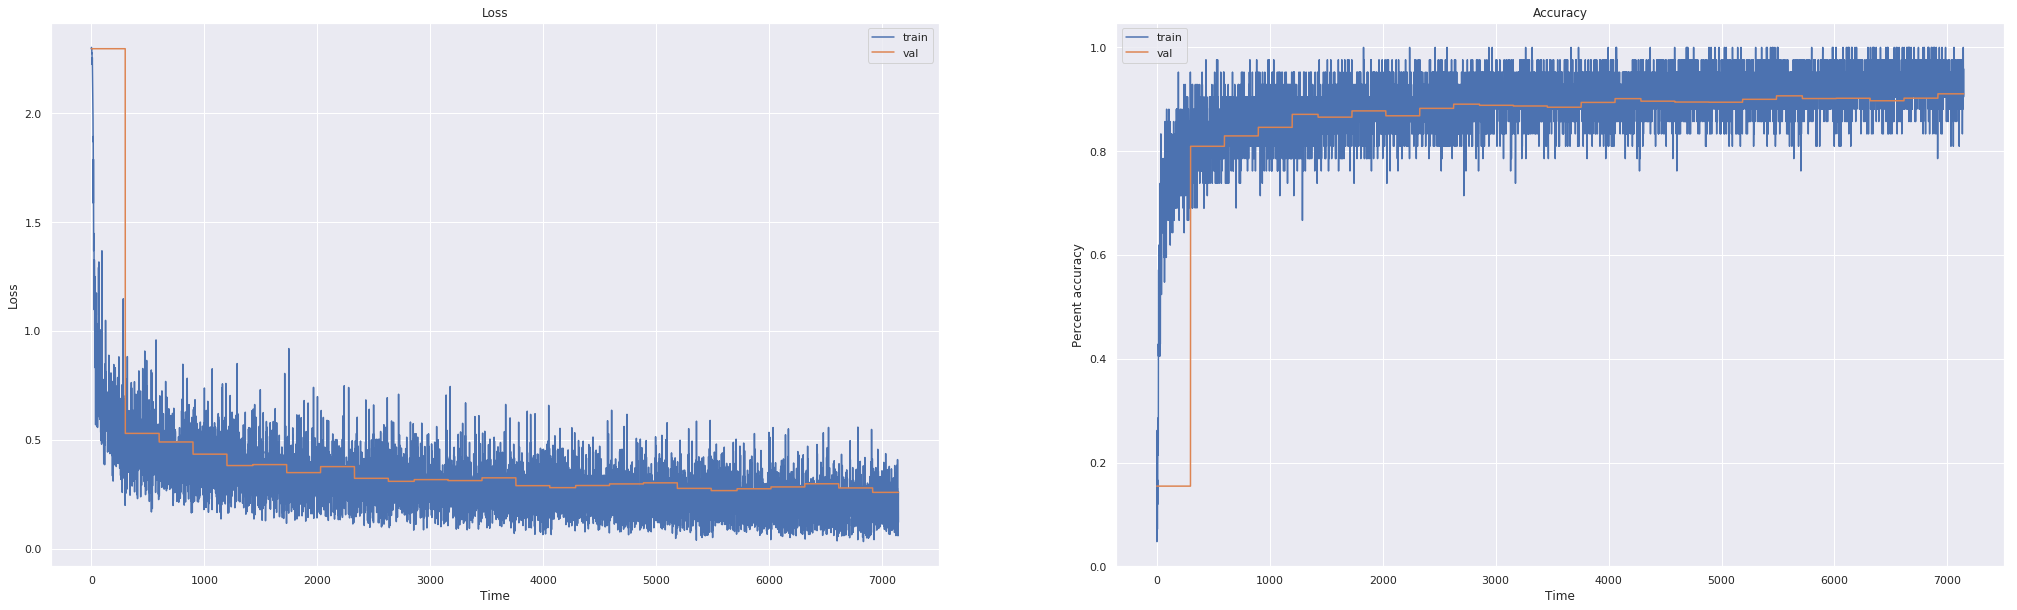

In [7]:

import seaborn as sns
sns.set_style('whitegrid')
custom = sns.color_palette("Paired", 9)
sns.set_palette(custom)
sns.set()

print(f'\n   --- Total time elapsed: {elapsed_time:.2f} ---\n')

# a, b = zip(*validations)

plt.rcParams['figure.figsize'] = [35, 10]
fig, axs = plt.subplots(1, 2)

axs[0].plot(losses, label='train')
axs[0].plot(validations, label='val')
axs[0].legend()
axs[0].set_title('Loss')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Loss')
axs[0].grid(True)

axs[1].plot(train_scores, label='train')
axs[1].plot(val_scores, label='val')
axs[1].legend()
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Percent accuracy')
axs[1].grid(True)


plt.show()


In [8]:

# both of these will be necessary for the softmax part plus the torch.log idea
# a = torch.from_numpy(np.random.randn(42,10,1).astype(np.float32))
# b = torch.exp(a)

# z = a / b.sum(1, keepdim=True)  # makes a row arr with broadcastable shape for a / b.sum


In [9]:
# index tensor more easily
# a = torch.from_numpy(np.random.randn(3,10,1).astype(np.float32))
# b = torch.exp(a)
# i = torch.from_numpy(np.random.randint(0,10,3))  # 3 random ints btw 0 and 10 for indices
# r = torch.arange(b.size(0))
# c = i

# b[r,c]  # call .mean(), or = 0



 ___

 ### Part 1
 Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

 **TODO:**

 * CrossEntropyLoss
 * Conv2D

 **DONE:**

 ___

 ### Part 2
 Implement a few initialization strategies which can include Xe initialization
 (sometimes called Xavier), Orthogonal initialization, and uniform random.
 You can specify which strategy you want to use with a parameter.



 Helpful links include:
 *  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
 *  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

 **TODO:**
 * Parameterize custom Conv2D for different initilization strategies
 * Xe
 * Orthogonal
 * Uniform

 **DONE:**



In [10]:
# class CrossEntropyLoss(nn.Module):
#     pass

# class Conv2d(nn.Module):
#     pass


# #%%
# class ConvNetwork(nn.Module):
#     pass



In [11]:
# Initialize Datasets

# Initialize DataLoaders

# Initialize Model

# Initialize Objective and Optimizer and other parameters



In [12]:

# Run your training and validation loop and collect stats



 ___

 ### Part 3
 Print the number of parameters in your network and plot accuracy of your training and validation
 set over time. You should experiment with some deep networks and see if you can get a network
 with close to 1,000,000 parameters.

 **TODO:**
 * Experiment with Deep Networks
 * Plot accuracy of training and validation set over time
 * Print out number of parameters in the model

 **DONE:**


In [13]:

# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy



In [14]:
# Compute and print the number of parameters in the model


 ___

 ### Part 4
 Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


 *Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

 * (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
 * (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**
 * (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **Your answer in bold here**
 * (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **Your answer in bold here**

 *Using a Kernel size of 5×5:*)

 * (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
 * (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
 * (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
 * (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

 *Using Kernel size of 5×3:*

 * (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **Your answer in bold here**
 * (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
 * (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
 * (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

 *Determine the kernel that requires the smallest padding size to make the following mappings possible:*

 * (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **Your answer in bold here**
 * (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**

 **TODO:**

 * Answer all the questions above

 **DONE:**


In [15]:
# Write some test code for checking the answers for these problems (example shown in the video)
